This notebook section provides visualizations and analysis of the autoencoder model's performance and outputs. The following cells include:

- Plotting a histogram of reconstruction errors to assess model accuracy.
- Displaying training and validation loss curves to monitor learning progress.
- Visualizing the learned latent space embeddings with a scatter plot.
- Instructions and code for exporting the trained PyTorch model to ONNX format and visualizing its architecture using Netron.

In [2]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns

from PyISV.utils.IO_utils import find_project_root
from PyISV.neural_network import NeuralNetwork  # Import your model class

RUN_ID = "nonMin_to_min_nPt_85"

# Set seaborn style
sns.set_theme(style="whitegrid")

# Common project paths
root_dir = find_project_root()
data_dir = os.path.join(root_dir, "datasets")
model_dir = os.path.join(root_dir, "models/", RUN_ID)
outputs_dir = os.path.join(model_dir, "outputs")
norms_dir = os.path.join(model_dir, "norms")
stats_dir = os.path.join(model_dir, "stats")

In [3]:
def run_model(model, model_file, input_file, norms_dir) -> tuple:
    # Load model weights
    checkpoint = torch.load(model_file, map_location="cpu")
    state_dict = checkpoint.get("model_state_dict", checkpoint)
    new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    model.to("cpu")
    model.load_state_dict(new_state_dict)
    model.eval()

    # Load and normalize input
    if input_file.endswith('.npy'):
        inputs = np.load(input_file)
        inputs_tensor = torch.from_numpy(inputs).float()
    elif input_file.endswith('.pt'):
        inputs_tensor = torch.load(input_file).to("cpu")

    subval = torch.from_numpy(np.load(f'{norms_dir}/subval_inputs.npy')).to("cpu")
    divval = torch.from_numpy(np.load(f'{norms_dir}/divval_inputs.npy')).to("cpu")
    inputs_norm = (inputs_tensor - subval) / divval

    # Model inference
    with torch.no_grad():
        outputs_norm = model(inputs_norm)
        latent = model.get_embedding(inputs_norm)

    # Denormalize for visualization
    subval_out = torch.from_numpy(np.load(f'{norms_dir}/subval_targets.npy')).to("cpu")
    divval_out = torch.from_numpy(np.load(f'{norms_dir}/divval_targets.npy')).to("cpu")
    outputs = outputs_norm * divval_out + subval_out

    return inputs_tensor, outputs, latent

In [4]:
from PyISV.utils.IO_utils import import_config

params = import_config(json_file=f"{model_dir}/config.json", param_dict=None)
model = NeuralNetwork(params['MODEL'])
inputs, outputs, latent = run_model(
    model=model,
    model_file=f"{model_dir}/model.pt",
    input_file=f"{data_dir}/RDFs/min_nPt_85.pt",
    norms_dir=norms_dir
)

print(f"Input shape: {inputs.shape}")
print(f"Output shape: {outputs.shape}")
print(f"Latent shape: {latent.shape}")

/home/shared_folder/venv/lib/python3.9/site-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(


Input shape: torch.Size([96000, 1, 340])
Output shape: torch.Size([96000, 1, 340])
Latent shape: torch.Size([96000, 3])


Inputs shape: torch.Size([96000, 1, 340])
Outputs shape: torch.Size([96000, 1, 340])


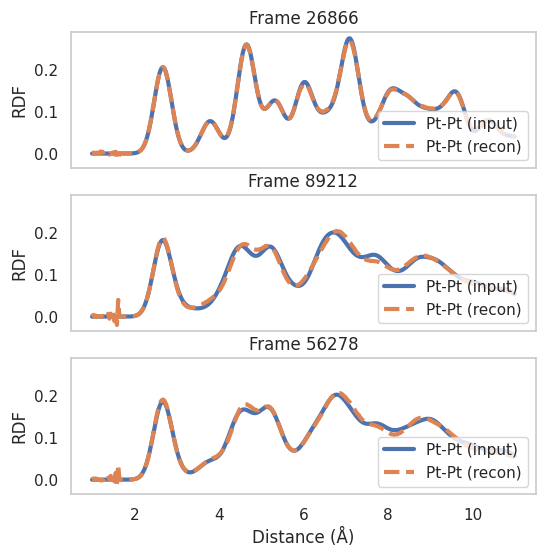

In [9]:
def plot_rdf(rdf, n_bins, min_dist, max_dist, species, ls=None, lw=None, label="", frame_idx=0, ax=None) -> None:
    """Plot RDFs for a specific frame"""
    if rdf.dim() > 3:  # If we have [frames, channels, 1, bins]
        rdf_frame = rdf[frame_idx].squeeze(1)  # Remove extra dimension
    else:
        rdf_frame = rdf[frame_idx]
    
    if not ax:
        ax = plt.subplot()
    pairs = []
    for i, s1 in enumerate(species):
        for j, s2 in enumerate(species):
            if j >= i:
                pairs.append(f"{s1}-{s2}")
    
    # Plot each channel with correct pair label
    for i, pair in enumerate(pairs):
        if i < rdf_frame.shape[0]:  # Make sure we don't exceed number of channels
            # Ensure data is 1D for plotting
            y_data = rdf_frame[i].cpu().numpy().flatten()
            sns.lineplot(
                x=np.linspace(min_dist, max_dist, n_bins), 
                y=y_data,
                label=pair+label, 
                ax=ax,
                linestyle=ls if ls else '-',
                linewidth=lw if lw else 1.5,    
            )
    ax.set_xlabel("Distance (Å)")
    ax.set_ylabel("RDF")
    ax.legend(loc="lower right")
    ax.set_title(f"Frame {frame_idx}")
    ax.grid(False)

import random
idx_samples = random.sample(range(inputs.shape[0]), 3)
n_samples = len(idx_samples)

fig, axes = plt.subplots(n_samples, 1, sharey=True, sharex=True, 
                         figsize=(6, 2 * n_samples))

for i, ax in enumerate(axes):
    for j, rdf in enumerate([inputs, outputs]):
        label = " (input)" if j == 0 else " (recon)"   
        plot_rdf(rdf, n_bins=340,
                min_dist=1.0,
                max_dist=11.0,
                species=["Pt"],
                frame_idx=idx_samples[i],
                ax=ax,
                label=label,
                ls='-' if j == 0 else '--', 
                lw=3)

print(f"Inputs shape: {inputs.shape}")
print(f"Outputs shape: {outputs.shape}")

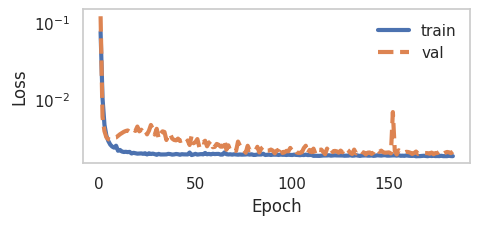

In [12]:
def plot_loss_curve(stats_file) -> None:
    """
    Plot the training and validation loss curves from a CSV file using seaborn.
    """
    stats = np.load(stats_file, allow_pickle=True)
    stats = {k: v for k, v in stats.items() if v.size > 0}  # Filter out empty arrays

    df = pd.DataFrame({key: stats[key] for key in stats})
    fig, ax = plt.subplots(1,1, figsize=(5,2))
    sns.lineplot(x=df['epoch'], y=df['train_loss'],lw=3, ls='-', label='train', ax=ax)
    sns.lineplot(x=df['epoch'], y=df['val_loss'], lw=3, ls='--', label='val', ax=ax)
    ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
    ax.legend(frameon=False)
    ax.grid(False)
    ax.set_yscale('log')

plot_loss_curve(
    os.path.join(f'{stats_dir}', f'stats.npz')
)

Embeddings shape: (96000, 3)


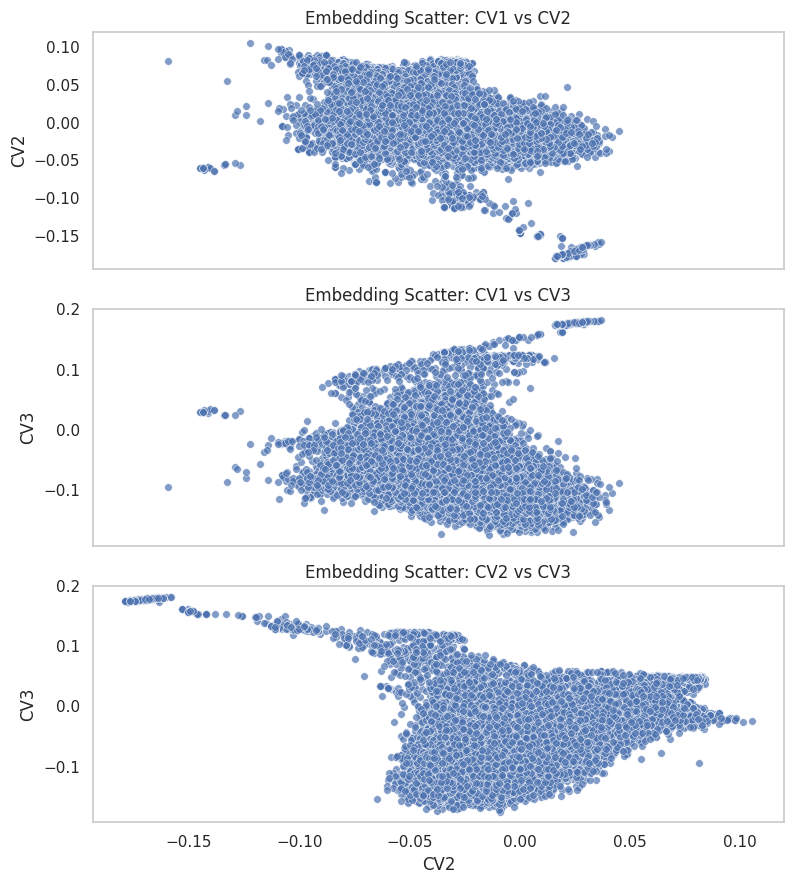

In [13]:
from itertools import combinations

def embedding_scatter_all_combinations(embeddings, labels=None) -> None:
    print(f"Embeddings shape: {embeddings.shape}")
    n_dims = embeddings.shape[1]
    combs = list(combinations(range(n_dims), 2))  # Generate all 2D combinations of dimensions

    fig, axes = plt.subplots(len(combs), 1, figsize=(8, 3 * len(combs)), sharex=True)  # Create subplots
    if len(combs) == 1:  # Handle case where only one combination exists
        axes = [axes]

    for ax, (dim1, dim2) in zip(axes, combs):
        sns.scatterplot(
            x=embeddings[:, dim1],
            y=embeddings[:, dim2],
            ax=ax,
            s=30,
            hue=labels,
            palette='viridis' if labels else None,
            alpha=0.7
        )
        ax.set_xlabel(f'CV{dim1 + 1}')
        ax.set_ylabel(f'CV{dim2 + 1}')
        ax.set_title(f'Embedding Scatter: CV{dim1 + 1} vs CV{dim2 + 1}')
        ax.grid(False)

    plt.tight_layout()

# Call the function with your latent embeddings
#true_labels = pd.read_csv(f"{data_dir}/Ag38_labels/combined_isv_labels_2D_nonMin_to_min_k15_nCu_0.dat", header=None).values.flatten()
embedding_scatter_all_combinations(latent.cpu().numpy())

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=6)  # Adjust the number of clusters
clusters = kmeans.fit_predict(latent.cpu().numpy())

score = silhouette_score(latent.cpu().numpy(), clusters)
print(f"Silhouette Score: {score}")

Silhouette Score: 0.570178210735321


Embeddings shape: (96000, 3)


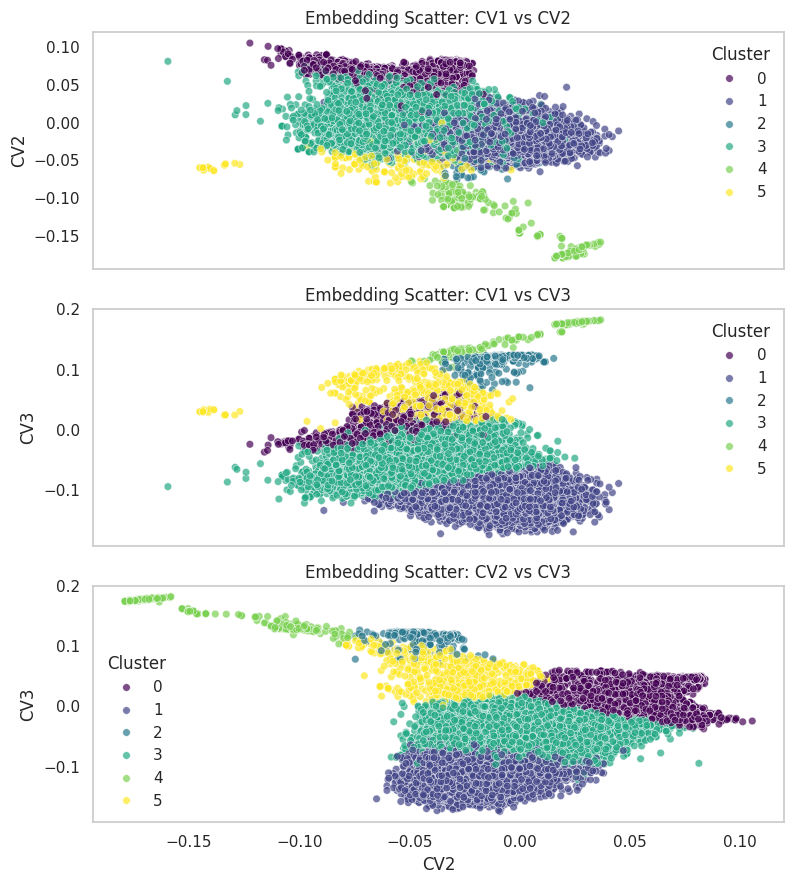

In [15]:
from itertools import combinations

def embedding_scatter_all_combinations_with_clusters(embeddings, clusters) -> None:
    """
    Plot all 2D combinations of embedding dimensions, colored by cluster labels.
    """
    print(f"Embeddings shape: {embeddings.shape}")
    n_dims = embeddings.shape[1]
    combs = list(combinations(range(n_dims), 2))  # Generate all 2D combinations of dimensions

    fig, axes = plt.subplots(len(combs), 1, figsize=(8, 3 * len(combs)), sharex=True)  # Create subplots
    if len(combs) == 1:  # Handle case where only one combination exists
        axes = [axes]

    for ax, (dim1, dim2) in zip(axes, combs):
        sns.scatterplot(
            x=embeddings[:, dim1],
            y=embeddings[:, dim2],
            hue=clusters,  # Color points by cluster labels
            palette="viridis",  # Choose a color palette
            ax=ax,
            s=30,
            alpha=0.7
        )
        ax.set_xlabel(f'CV{dim1 + 1}')
        ax.set_ylabel(f'CV{dim2 + 1}')
        ax.set_title(f'Embedding Scatter: CV{dim1 + 1} vs CV{dim2 + 1}')
        ax.legend(title="Cluster", loc="best", frameon=False)
        ax.grid(False)

    plt.tight_layout()

embeddings = latent.cpu().numpy()
embedding_scatter_all_combinations_with_clusters(embeddings, clusters)

## Export PyTorch Model to ONNX and Visualize with Netron

This section demonstrates how to export your trained PyTorch model to the ONNX format and visualize its architecture using Netron.



**Steps:**

1. Load your model class and weights.

2. Create a dummy input tensor matching your model's input shape.

3. Export the model to ONNX.

4. Visualize the ONNX file with Netron.



> **Note:** You must have the model class definition available in the notebook. If it's in another file, import it accordingly. Adjust the dummy input shape if your model expects a different input.

In [ ]:
# Visualize with Netron
# Can be installed via pip: pip install netron
# or conda: conda install -c conda-forge netron
import netron

onnx_path = f"{model_dir}/model.onnx"
netron.start(onnx_path)
# This will open a browser window with the model visualization.